# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join

# 1. Reading the results

We read the results from text files into Pandas DataFrames for analysis.

In [5]:
# Read all results from txt files

parameter_e_path = "./parameter_tuning/"
parameter_e_files = [f for f in listdir(parameter_e_path) if isfile(join(parameter_e_path, f))]

performance_path = "./performance/"
performance_files = [f for f in listdir(performance_path) if isfile(join(performance_path, f))]

compare_path = "./compare/"
compare_files = [f for f in listdir(compare_path) if isfile(join(compare_path, f))]



# Parameter Setting (ACO & CLu): evaporation-factor/erasure-probability
column_names = ["Data-set", "Size", "Algorithm", "Support", "Run-time", "Cluster-time", "Patterns", "Pattern-count", "Misclustered-patterns", "Support-error", "E"]
df_pe = pd.DataFrame(columns = column_names)

for file in parameter_e_files:
    f_path = join(parameter_e_path,file)
    try:
        res = pd.read_csv(f_path, names=["A","B"], sep = ':', header=None, engine='python')
    except Exception:
        print(f_path)
    
    run = float(res['B'][0][0:6]) # run-time
    # mem = str(res['B'][1]) # memory
    alg = str(res['B'][1]) # algorithm
    att = int(res['B'][2]) # number of attributes in the data set
    size = int(res['B'][3])  # data set size
    evp = float(res['B'][4]) # evaporation-factor / erasure-probability
    # mit = int(res['B'][5]) # maximum iteraction count
    sup = float(res['B'][6]) # minimum support
    pat = int(res['B'][8]) # patterns        
    
    if alg == " Clu-GRAD (v1.9)":
        clu = float(res['B'][9][0:6]) # cluster-time
        
        # Fetch patterns to test accuracy
        miss = 0
        gps = [""] * pat
        errs = np.zeros(pat)  #[0.0] * pat
        gp_pos = res.loc[res['A'] == 'Comparison '].index[0] + 1 # 1st position
        for i in range(pat):
            pos = i + gp_pos
            sups = str(res['B'][pos])
            gps[i] = [res['A'][pos], sups]
            sup_arr = sups.split(", ")
            est_sup = float(sup_arr[0])
            true_sup = float(sup_arr[1])
            if true_sup > 0:
                temp_err = (true_sup - est_sup) / true_sup
                errs[i] = abs(temp_err)
            else:
                miss += 1
        # print(errs)
        error_rate = errs.mean()
    else:
        gps = [""] * pat
        gp_pos = res.loc[res['A'] == 'Pattern '].index[0] + 1 # 1st position
        for i in range(pat):
            pos = i + gp_pos
            gps[i] = [res['A'][pos], float(res['B'][pos])]
        clu = 0
        miss = 0
        error_rate = 0
    if att == 10:
        col = "BCR"
    elif att == 15:
        col = "AQY"
    elif att == 98:
        col = "C2K"
    elif att == 170:
        col = "APS"
    else:
        col = ""
        
    # df_pe = df_pe.append({"Data-set": col, "Size": size, "Algorithm":alg, "Support": sup, "Run-time":run, "Cluster-time":clu, "Patterns":gps, "Pattern-count":pat, "Misclustered-patterns":miss, "Support-error":error_rate, "E": evp}, ignore_index=True)
    df_pe = pd.concat([df_pe, pd.DataFrame({"Data-set": col, "Size": size, "Algorithm":alg, "Support": sup, "Run-time":run, "Cluster-time":clu, "Patterns":gps, "Pattern-count":pat, "Misclustered-patterns":miss, "Support-error":error_rate, "E": evp})])

df_pe['Algorithm'].replace({' Clu-GRAD (v1.9)' : 'CluGRAD'}, inplace=True)
df_pe['Algorithm'].replace({' ACO-GRAANK (v4.0)' : 'ACoGRAD'}, inplace=True)









# Accuracy Performance (CLu)
column_names = ["Data-set", "Size", "Features", "Cluster Algorithm", "Support", "Run-time", "Cluster-time", "Patterns", "Pattern-count", "TP", "TN", "FP", "FN", "Support-error", "E" ]
df_perf = pd.DataFrame(columns = column_names)
for file in performance_files:
    f_path = join(performance_path,file)
    try:
        res = pd.read_csv(f_path, names=["A","B"], sep = ':', header=None, engine='python')
    except Exception:
        print(f_path)
    
    run = float(res['B'][0][0:6]) # run-time
    # mem = str(res['B'][1]) # memory
    alg = str(res['B'][2]) # algorithm
    att = int(res['B'][3]) # number of attributes in the data set
    size = int(res['B'][4])  # data set size
    
    er_p = float(res['B'][5]) # evaporation-factor / erasure-probability
    # mit = int(res['B'][6]) # maximum iteraction count
    c_alg = str(res['B'][7]) # clustering algorithm
    sup = float(res['B'][8]) # minimum support
    pat = int(res['B'][10]) # patterns
    clu = float(res['B'][11][0:6]) # cluster-time
        
    # Fetch patterns to test accuracy
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    miss = 0
    gps = [""] * pat
    errs = np.zeros(pat)  # [0.0] * pat
    gp_pos = res.loc[res['A'] == 'Comparison '].index[0] + 1 # 1st position
    for i in range(pat):
        pos = i + gp_pos
        sups = str(res['B'][pos])
        gps[i] = [res['A'][pos], sups]
        sup_arr = sups.split(", ")
        est_sup = float(sup_arr[0])
        true_sup = float(sup_arr[1])
        # Compute TP, TN, FP, FN
        if (est_sup >= sup) and (true_sup >= sup):
            tp += 1
            temp_err = (true_sup - est_sup) / true_sup
            errs[i] = abs(temp_err)
        elif ((est_sup >= 0) and (est_sup < sup)) and (true_sup < sup):
            tn += 1
            if true_sup > 0:
                temp_err = (true_sup - est_sup) / true_sup
                errs[i] = abs(temp_err)
        elif (est_sup >= sup) and (true_sup < sup):  # less than support or -1
            fp += 1
            miss += 1
        elif ((est_sup > 0) and (est_sup < sup)) and (true_sup >= sup):
            fn += 1
            miss += 1
        
        # if true_sup > 0:
        #    temp_err = (true_sup - est_sup) / true_sup
        #    errs[i] = abs(temp_err)
        # else:
        #    miss += 1
    actual_errs = errs[np.nonzero(errs)]
    if actual_errs.size > 0:
        error_rate = actual_errs.mean()
    else:
        error_rate = 0
    
    # Fetch patterns
    gps = [""] * pat
    gp_pos = res.loc[res['A'] == 'Pattern '].index[0] + 1 # 1st position
    for i in range(pat):
        pos = i + gp_pos
        gps[i] = [res['A'][pos], float(res['B'][pos])]
    
    if att == 10:
        col = "BCR"
    elif att == 15:
        col = "AQY"
    elif att == 98:
        col = "C2K"
    elif att == 21:
        if size == 15402:
            col = "DIR_15k"
        else:
            col = "DIR_8k"
    elif att == 170:
        col = "APS"
    else:
        col = ""

    df_perf = pd.concat([df_perf, pd.DataFrame({"Data-set": col, "Size": size, "Features": att, "Cluster Algorithm":c_alg, "Support":sup, "Run-time":run, "Cluster-time":clu, "Patterns":gps, "Pattern-count":pat, "TP":tp, "TN":tn, "FP": fp, "FN": fn, "Support-error":error_rate, "E":er_p})])





















# Comparison Experiment (ACO & CLu & GRA)
column_names = ["Data-set", "Size", "Features", "Algorithm", "Support", "Run-time", "Cluster-time", "Memory", "Patterns", "Pattern-count", "Misclustered-patterns", "Support-error", "E"]
df_comp = pd.DataFrame(columns = column_names)
for file in compare_files:
    f_path = join(compare_path,file)
    try:
        res = pd.read_csv(f_path, names=["A","B"], sep = ':', header=None, engine='python')
    except Exception:
        print(f_path)
    
    run = float(res['B'][0][0:6]) # run-time
    mem = str(res['B'][1]) # memory
    alg = str(res['B'][2]) # algorithm
    att = int(res['B'][3]) # number of attributes in the data set
    size = int(res['B'][4])  # data set size

    if alg == " GRAANK ":
        evp = 0
        # mit = 0
        sup = float(res['B'][5]) # minimum support
        pat = int(res['B'][7]) # patterns
    else:
        evp = float(res['B'][5]) # evaporation-factor / erasure-probability
        # mit = int(res['B'][6]) # maximum iteraction count
    
        sup = float(res['B'][7]) # minimum support
        pat = int(res['B'][9]) # patterns
        
    if alg == " Clu-GRAD (v1.9)":
        clu = float(res['B'][10][0:6]) # cluster-time
        
        # Fetch patterns to test accuracy
        miss = 0
        gps = [""] * pat
        errs = np.zeros(pat)  #[0.0] * pat
        gp_pos = res.loc[res['A'] == 'Comparison '].index[0] + 1 # 1st position
        for i in range(pat):
            pos = i + gp_pos
            sups = str(res['B'][pos])
            gps[i] = [res['A'][pos], sups]
            sup_arr = sups.split(", ")
            est_sup = float(sup_arr[0])
            true_sup = float(sup_arr[1])
            if true_sup > 0:
                temp_err = (true_sup - est_sup) / true_sup
                errs[i] = abs(temp_err)
            else:
                miss += 1
        error_rate = errs.mean()
    else:
        clu = 0
        miss = 0
        error_rate = 0
    
    # Fetch patterns
    gps = [""] * pat
    gp_pos = res.loc[res['A'] == 'Pattern '].index[0] + 1 # 1st position
    for i in range(pat):
        pos = i + gp_pos
        gps[i] = [res['A'][pos], float(res['B'][pos])]
    
    if att == 10:
        col = "BCR"
    elif att == 15:
        col = "AQY"
    elif att == 98:
        col = "C2K"
    elif att == 21:
        if size == 15402:
            col = "DIR_15k"
        else:
            col = "DIR_8k"
    elif att == 170:
        col = "APS"
    else:
        col = ""
    # df_comp = df_comp.append({"Data-set": col, "Size": size, "Features": att, "Algorithm":alg, "Support": sup, "Run-time":run, "Cluster-time":clu, "Memory":mem, "Patterns":gps, "Pattern-count":pat, "Misclustered-patterns":miss, "Support-error":error_rate, "E": evp}, ignore_index=True)
    df_comp = pd.concat([df_comp, pd.DataFrame({"Data-set": col, "Size": size, "Features": att, "Algorithm":alg, "Support": sup, "Run-time":run, "Cluster-time":clu, "Memory":mem, "Patterns":gps, "Pattern-count":pat, "Misclustered-patterns":miss, "Support-error":error_rate, "E": evp})])

df_comp['Algorithm'].replace({' Clu-GRAD (v1.9)' : 'CluGRAD'}, inplace=True)
df_comp['Algorithm'].replace({' ACO-GRAANK (v4.0)' : 'ACoGRAD'}, inplace=True)


# df_pe
# df_comp
df_perf

./performance/.DS_Store


,Data-set,Size,Features,Cluster Algorithm,Support,Run-time,Cluster-time,Patterns,Pattern-count,TP,TN,FP,FN,Support-error,E
0,DIR_8k,8074,21,dbscan,0.5,519.100,2.128,"[['2+', '2-', '3+', '3-', '4+', '4-', '5+', '5...",1,0,1,0,0,0,0.9
0,BCR,116,10,dbscan,0.5,0.085,0.010,"[['0+', '0-', '1+', '1-', '2+', '2-', '3+', '3...",1,0,1,0,0,0,0.9
0,DIR_8k,8074,21,kmeans,0.5,364.600,3.007,"[['2-', '10-', '14-'] , 0.781]",7,6,1,0,0,0.007247,0.9
1,DIR_8k,8074,21,kmeans,0.5,364.600,3.007,"[['17+', '17-'] , 0.0]",7,6,1,0,0,0.007247,0.9
2,DIR_8k,8074,21,kmeans,0.5,364.600,3.007,"[['2+', '5+', '8+', '10+', '11+', '14+'] , 0.678]",7,6,1,0,0,0.007247,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,APS,2473,170,birch,0.5,299.100,0.836,"[['20-', '21-'] , 0.879]",75,47,8,20,0,0.078905,0.9
74,APS,2473,170,birch,0.5,299.100,0.836,"[['20+', '21+'] , 0.958]",75,47,8,20,0,0.078905,0.9
0,DIR_8k,8074,21,spectral,0.5,387.200,2.436,"[['3-', '4+', '5-', '7+', '9+', '10+', '14-', ...",3,0,3,0,0,0,0.9
1,DIR_8k,8074,21,spectral,0.5,387.200,2.436,"[['2+', '5+', '6+', '9-', '14+', '16+', '18+']...",3,0,3,0,0,0,0.9


# 2. Parameter Tuning 
## (Evaporation Factor/Erasure Probability)

We conduct an analysis to determine:

* The optimum max-iteration for estimating score-vectors for the Clu-GRAD algorithm.

* The optimum values for evaporation-factor (ACO-GRAD) and erasure-probability (CLu-GRAD).



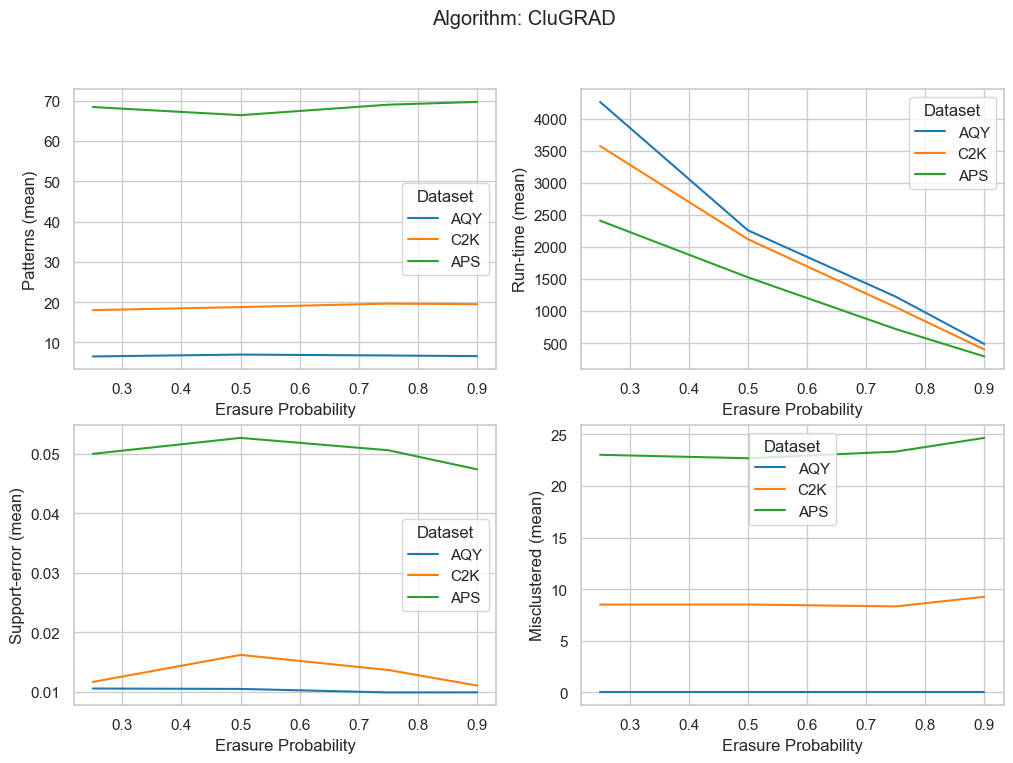

,Dataset,Algorithm,EFactor/ EProbability,Patterns (mean),Patterns (std),Misclustered (mean),Misclustered (std),Support-error (mean),Support-error (std),Run-time (mean),Run-time (std)
0,AQY,CluGRAD,0.25,6.538462,0.508391,0.000000,0.000000,0.010514,0.000143,4258.615385,488.896560
1,AQY,CluGRAD,0.50,7.000000,0.000000,0.000000,0.000000,0.010449,0.000228,2259.500000,59.525594
2,AQY,CluGRAD,0.75,6.777778,0.423659,0.000000,0.000000,0.009854,0.000703,1225.962963,123.742438
3,AQY,CluGRAD,0.90,6.615385,0.803837,0.000000,0.000000,0.009872,0.001372,487.734615,53.269593
4,C2K,CluGRAD,0.25,18.027778,0.711519,8.513889,0.503315,0.011621,0.002357,3572.125000,319.838865
5,C2K,CluGRAD,0.50,18.786667,0.842989,8.520000,0.502964,0.016177,0.004319,2121.200000,73.172879
6,C2K,CluGRAD,0.75,19.641026,1.697778,8.333333,1.296015,0.013633,0.003425,1062.105128,83.233026
7,C2K,CluGRAD,0.90,19.512821,0.503071,9.269231,0.832350,0.011020,0.002693,403.000000,9.085224
8,APS,CluGRAD,0.25,68.414634,2.332377,23.024390,1.426084,0.050036,0.001156,2409.243902,86.661043
9,APS,CluGRAD,0.50,66.396985,2.066616,22.688442,1.236408,0.052721,0.003727,1527.497487,35.328455


In [9]:

data_sets = ['AQY', 'C2K', 'APS']
algorithms = ['CluGRAD']#, 'ACoGRAD', 'GRAANK']
evals_e = [0.25, 0.5, 0.75, 0.9]

eval_data_e = []


# Only include these columns
df_res = df_pe[["Data-set", "Algorithm", "Support", "Run-time", "Cluster-time", "Pattern-count", "Misclustered-patterns", "Support-error", "Patterns", 'E']]

for ds in data_sets:
    df1 = df_res.loc[df_res['Data-set'] == ds]

    for alg in algorithms:
        df2 = df1.loc[df1['Algorithm'].str.contains(alg)]
        # print(df1)
        for ev in evals_e:
            df3 = df2.loc[df2['E'] == ev]
            if not df3.empty:
                # print(df2)
                pat_arr = []
                for index,row in df3.iterrows():
                    # 10/100/1000 evaluations
                    pat_arr.append(row['Patterns'])
                    # print(pat_arr)
                eval_data_e.append([ds, alg, ev, df3['Pattern-count'].mean(), df3['Pattern-count'].std(), df3['Misclustered-patterns'].mean(), df3['Misclustered-patterns'].std(), df3['Support-error'].mean(), df3['Support-error'].std(), df3['Run-time'].mean(), df3['Run-time'].std()])
                       
df_data_2 = pd.DataFrame(data=eval_data_e, columns=['Dataset', 'Algorithm', 'EFactor/ EProbability', 'Patterns (mean)', 'Patterns (std)', 'Misclustered (mean)', 'Misclustered (std)', 'Support-error (mean)', 'Support-error (std)', 'Run-time (mean)', 'Run-time (std)'])


# Plotting the results 
sns.set_theme(style="whitegrid")

for alg in algorithms:
    df1 = df_data_2.loc[df_data_2['Algorithm'] == alg]
    
    if alg == 'ACoGRAD':
        x_label = "Evaporation Factor"
    elif alg == 'CluGRAD':
        x_label = "Erasure Probability"
    
    fig = plt.figure(figsize=(12,8))
    plt.subplot(2, 2, 1)
    sns.lineplot(data=df1, x="EFactor/ EProbability", y="Patterns (mean)", hue="Dataset", palette="tab10")  # markers=True)
    plt.xlabel(x_label)
    plt.subplot(2, 2, 2)
    sns.lineplot(data=df1, x="EFactor/ EProbability", y="Run-time (mean)", hue="Dataset", palette="tab10")  # markers=True)
    plt.xlabel(x_label)
    
    plt.subplot(2, 2, 3)
    sns.lineplot(data=df1, x="EFactor/ EProbability", y="Support-error (mean)", hue="Dataset", palette="tab10")  # markers=True)
    plt.xlabel(x_label)
    
    plt.subplot(2, 2, 4)
    sns.lineplot(data=df1, x="EFactor/ EProbability", y="Misclustered (mean)", hue="Dataset", palette="tab10")  # markers=True)
    plt.xlabel(x_label)

    fig.suptitle('Algorithm: ' + alg)
plt.show()
df_data_2


# 3. Analysis of Clu-GRAD Algorithm
We analyze the performance and accuracy of the Clu-GRAD algorithm on 4 data sets.

In [4]:
data_sets = ['BCR', 'DIR_15k', 'DIR_8k', 'C2K', 'APS'] #, 'AQY']
algorithms = ['ACoGRAD', 'CluGRAD', 'GRAANK']


# Only include these columns
df_res = df_comp[["Data-set", "Algorithm", "Size", "Features", "Memory", "Run-time", "Cluster-time", "Pattern-count", "Misclustered-patterns", "Support-error"]]
# df_res1 = df_comp[["Data-set", "Algorithm", "Run-time", "Cluster-time", "Pattern-count", "Misclustered-patterns", "Support-error"]]
# df_res2 = df_comp[["Data-set", "Algorithm", "Memory"]]

data = []
for ds in data_sets:
    df1 = df_res.loc[df_res['Data-set'] == ds]
    
    for alg in algorithms:
        df2 = df1.loc[df1['Algorithm'].str.contains(alg)]
        
        memory_arr = []
        for index,row in df2.iterrows():
            conv_str = str(row['Memory']).replace(' [', '').replace('] ', '').split(',')
            #conv_str = conv_str.split(',')
            memory_arr.append(np.array(conv_str, dtype=float))
        # memory_arr = np.array(conv_str, dtype=float)
        if len(memory_arr) == 0:
            # print(str(alg) + ': ' + str(ds))
            continue
        else:   
            size = int(df2['Size'].median())
            features = int(df2['Features'].median())
            data.append([ds, alg, memory_arr[0], size, features, df2['Run-time'].mean(), df2['Run-time'].std(), df2['Cluster-time'].mean(), df2['Cluster-time'].std(), df2['Pattern-count'].mean(), df2['Pattern-count'].std(), df2['Misclustered-patterns'].mean(), df2['Misclustered-patterns'].std(), df2['Support-error'].mean(), df2['Support-error'].std()])

df_data = pd.DataFrame(data=data, columns=['Data-set', 'Algorithm', 'Memory', 'Size', 'Features', 'Run-time (mean)', 'Run-time (std)', 'Cluster-time (mean)', 'Cluster-time (std)', 'Patterns (mean)', 'Patterns (std)', 'Misclustered-patterns (mean)', 'Misclustered-patterns (std)', 'Support-error (mean)', 'Support-error (std)'])
df_a = df_data[['Data-set', 'Algorithm', 'Run-time (mean)', 'Run-time (std)', 'Patterns (mean)', 'Patterns (std)']]
df_b = df_data[['Data-set', 'Algorithm', 'Memory']]
df_c = df_data[['Data-set', 'Algorithm', 'Size', 'Features', 'Run-time (mean)', 'Run-time (std)', 'Cluster-time (mean)', 'Cluster-time (std)', 'Patterns (mean)', 'Patterns (std)', 'Misclustered-patterns (mean)', 'Misclustered-patterns (std)', 'Support-error (mean)', 'Support-error (std)']]


In [5]:
#df_c = df_data[['Data-set', 'Algorithm', 'Size', 'Features', 'Run-time (mean)', 'Cluster-time (mean)', 'Patterns (mean)', 'Misclustered-patterns (mean)', 'Support-error (mean)']]
df_c[df_c.Algorithm == 'CluGRAD']

,Data-set,Algorithm,Size,Features,Run-time (mean),Run-time (std),Cluster-time (mean),Cluster-time (std),Patterns (mean),Patterns (std),Misclustered-patterns (mean),Misclustered-patterns (std),Support-error (mean),Support-error (std)
1,BCR,CluGRAD,116,10,0.423750,0.197336,0.354250,0.202632,3.000000,1.825742,0.000000,0.000000,0.056204,0.032976
4,DIR_15k,CluGRAD,15402,21,1466.333333,87.688844,8.195000,0.354806,6.666667,1.527525,0.000000,0.000000,0.007825,0.000774
6,DIR_8k,CluGRAD,8074,21,373.860000,12.236135,2.560800,0.177840,6.200000,0.447214,0.000000,0.000000,0.008103,0.000813
9,C2K,CluGRAD,3942,98,427.500000,41.051553,1.859667,0.124187,19.666667,2.081666,10.333333,2.081666,0.008661,0.003612
12,APS,CluGRAD,2473,170,315.042857,4.839028,1.210429,0.118092,76.857143,2.734262,17.428571,0.786796,0.044974,0.001777


# 4. Comparison of Algorithms

We run an experiment that analyses the computational performance of ACO-GRAD, Clu-GRAD and GRAANK on the 4 data sets.
We compare the computational performance of the 3 algorithms:

1. Run time
2. Memory utilization

## 4.1. Run-time Comparison


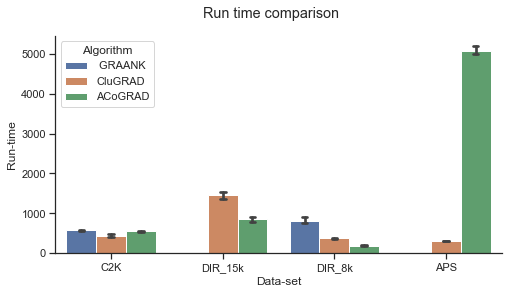

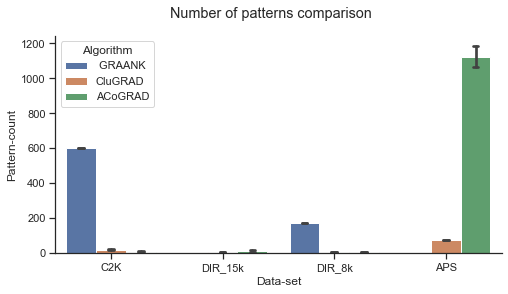

,Data-set,Algorithm,Run-time (mean),Run-time (std),Patterns (mean),Patterns (std)
0,BCR,ACoGRAD,0.086750,0.007544,4.500000,1.914854
1,BCR,CluGRAD,0.423750,0.197336,3.000000,1.825742
2,BCR,GRAANK,4.931000,0.493641,58.000000,0.000000
3,DIR_15k,ACoGRAD,847.700000,71.447090,13.250000,7.274384
4,DIR_15k,CluGRAD,1466.333333,87.688844,6.666667,1.527525
5,DIR_8k,ACoGRAD,193.000000,4.979290,6.250000,1.707825
6,DIR_8k,CluGRAD,373.860000,12.236135,6.200000,0.447214
7,DIR_8k,GRAANK,804.400000,86.178594,172.000000,0.000000
8,C2K,ACoGRAD,553.175000,8.388633,9.750000,3.947573
9,C2K,CluGRAD,427.500000,41.051553,19.666667,2.081666


In [6]:

df_plot = df_res.drop(df_res[df_res['Data-set'] == 'BCR'].index).drop(df_res[df_res['Data-set'] == 'AQY'].index)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
fig = plt.figure(figsize=(8,4))
fig.suptitle('Run time comparison')
ax = sns.barplot(x="Data-set", y="Run-time", hue="Algorithm", data=df_plot, capsize=.05)

fig = plt.figure(figsize=(8,4))
fig.suptitle('Number of patterns comparison')
ax = sns.barplot(x="Data-set", y="Pattern-count", hue="Algorithm", data=df_plot, capsize=.05)

# bars = ax.patches
# pattern=['..','xx','*']

# replace 2 with 7 in your code
# hatches=np.repeat(pattern,2)
# for pat,bar in zip(hatches,bars):
#    bar.set_hatch(pat)
# ax.legend()

plt.show()
df_a


## 5.2. Memory Utilization Comparison

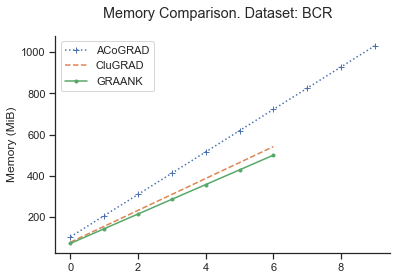

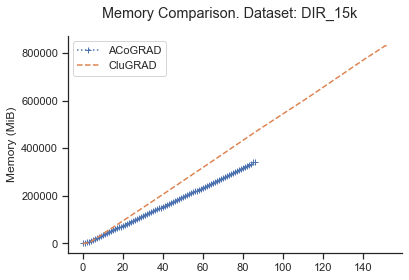

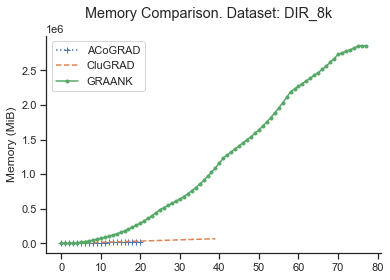

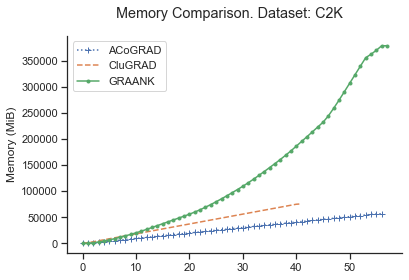

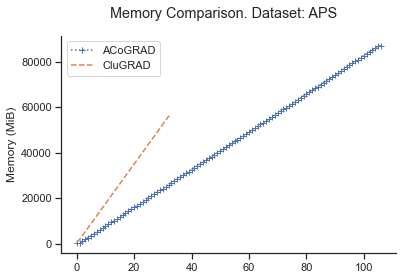

In [7]:

markers = ['+:', '--', '.-']
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

for ds in data_sets:
    df1 = df_b.loc[df_b['Data-set'] == ds]
                
    fig = plt.figure(figsize=(6,4))
    fig.suptitle('Memory Comparison. Dataset: ' + ds)
    plt.ylabel('Memory (MiB)')
    i = 0 # For markers
    
    for alg in algorithms:
        df2 = df1.loc[df1['Algorithm'].str.contains(alg)]
        
        mem = np.array(df2['Memory'])
        if mem.size > 0:
            mem = np.array(mem[0]).reshape(-1, 1)
            temp = np.random.randn(100,1)
            plt.plot(np.cumsum(mem), markers[i], label=alg)
            i += 1
            # plt.plot(mem, label=alg)
    plt.legend(loc="upper left")
#plt.show()


# 5. Extracted Gradual Patterns

These are the patterns extracted by the algorithms

In [8]:
data_sets = ['BCR', 'DIR', 'DIR_8k', 'C2K', 'AQY', 'APS']
algorithms = ['ACoGRAD', 'CluGRAD', 'GRAANK']


# Only include these columns
df_res = df_comp[["Data-set", "Algorithm", "Patterns"]]
# print(df_res)

data = []
for ds in data_sets:
    df1 = df_res.loc[df_res['Data-set'] == ds]
    
    print("\nDataset: " + str(ds))
    print("---------------\n")
    for alg in algorithms:
        df2 = df1.loc[df1['Algorithm'].str.contains(alg)]
        
        print("Algorithm: " + str(alg))
        print("Pattern: Support")
        
        for index,row in df2.iterrows():
            pat_str = list(row['Patterns'])#.split('],')
            print(str(pat_str[0][0]) + ': ' + str(pat_str[0][1]))



Dataset: BCR
---------------

Algorithm: ACoGRAD
Pattern: Support
['6-', '4+'] : 0.528
['6-', '8+'] : 0.575
['6-', '8+'] : 0.575
['4+', '3+', '1+'] : 0.583
Algorithm: CluGRAD
Pattern: Support
['1+', '5+'] : 0.702
['1-', '5-'] : 0.656
['0+', '2+'] : 0.545
['2-', '3-', '4-'] : 0.542
Algorithm: GRAANK
Pattern: Support
['2+', '0+'] : 0.544
['2+', '0+'] : 0.544
['2+', '0+'] : 0.544
['0+', '2+'] : 0.544
['2+', '0+'] : 0.544
['0+', '2+'] : 0.544

Dataset: DIR
---------------

Algorithm: ACoGRAD
Pattern: Support
Algorithm: CluGRAD
Pattern: Support
Algorithm: GRAANK
Pattern: Support

Dataset: DIR_8k
---------------

Algorithm: ACoGRAD
Pattern: Support
['5+', '10+', '6+', '11+'] : 0.523
['11+', '15+'] : 0.522
['12+', '6-'] : 0.514
['12+', '10+', '5+', '2+', '14+'] : 0.612
Algorithm: CluGRAD
Pattern: Support
['2-', '14-'] : 0.836
['2-', '14-'] : 0.836
['2-', '14-'] : 0.836
['2-', '14-'] : 0.836
['2-', '14-'] : 0.836
Algorithm: GRAANK
Pattern: Support
['2+', '4+'] : 0.519
['4+', '2+'] : 0.519
['4